<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/Structured_Dataset/blob/main/time_series_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)


##What is a time series problem?
Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.
What we're going to cover
Are you ready?

**We've got a lot to go through.**

* Get time series data (the historical price of Bitcoin)
* Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
* Creating training and test sets (the wrong way)
* Creating training and test sets (the right way)
* Visualizing time series data
* Turning time series data into a supervised learning problem (windowing)
* Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
* Dense (fully-connected) networks
* Sequence models (LSTM and 1D CNN)
* Ensembling (combining multiple models together)
* Multivariate models
* Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS 

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4fe074c7-3413-abb8-f1a5-908c51be1be4)


In [ ]:
# import function as :
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils  import plot_model
import csv
import os

In [ ]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-04-12 17:22:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-04-12 17:22:45 (17.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



###Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in CSV (comma separated values) format (a very common data format for time series), we'll use the pandas read_csv() function.

And because our data has a date component, we'll tell pandas to parse the dates using the parse_dates parameter passing it the name our of the date column ("Date").

In [ ]:
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], # parse the date column (tell pandas column 1 is a datetime)
                 index_col=["Date"]) 
df.head(5)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
## gettin the info of data table:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# let's create the dataframe with the required data column index and closing price:
# Also remane the closing price column name as price
btc_price=pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':'price'})
btc_price[:10]

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


In [ ]:
btc_price.price[2]

108.58483

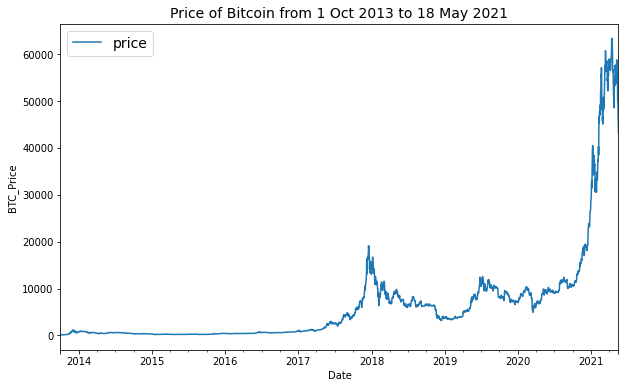

In [ ]:
## plot the graphs of price V/s Time (btc growth graph):
btc_price.plot(figsize=(10,6))
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=14)
plt.ylabel('BTC_Price')
plt.legend(fontsize=14);

## importing time series data with Python's CSV module

In [ ]:
timestep=[]
btc_prices=[]
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv','r')as file:
    csv_reader=csv.reader(file,delimiter=",")
    next(csv_reader)            # skip first line (this gets rid of the column titles)
    # lopping through csv_reader:
    for line in csv_reader:
        timestep.append(datetime.strptime(line[1],"%Y-%m-%d"))# get the dates as dates (not strings), strptime = string parse time
        btc_prices.append(float(line[2])) # get the closing price as float

In [ ]:
## let,s check it:
btc_prices[:10],timestep[:5]

([123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116],
 [datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0)])

In [ ]:
len(btc_prices)

2787

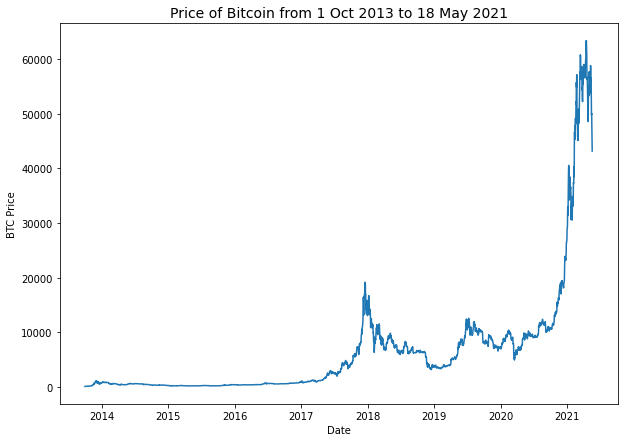

In [ ]:
# Plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(timestep, btc_prices)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=14)
plt.xlabel("Date")
plt.ylabel("BTC Price");

##Format Data Part 1: Creatining train and test sets for time series data


* **Univariate time** series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.

* **Multivariate time** series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.


In [ ]:
## getting the btc_prices in array
timesteps=btc_price.index.to_numpy()
prices=btc_price['price'].to_numpy()

In [ ]:
## checking:
btc_price['price'][:3]

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
Name: price, dtype: float64

In [ ]:
## checking:
timesteps[:4],prices[:4]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466]))

In [ ]:
# creating train and test split the right way for time series data:
#split size is the 80% of all the data:
split_size =int(0.8 * len(prices))

# create train and test splits: split upto 80 percent:
x_train,y_train=timesteps[:split_size],prices[:split_size]

# create test data splits  fron 80 to 100 ie.20%
x_test,y_test= timesteps[split_size:],prices[split_size:]

In [ ]:
#Checkingg the length:
len(x_train), len(x_test), len(y_train), len(y_test)  #,split_size # split size is wqual to x_train,y_train

(2229, 558, 2229, 558)

In [ ]:
y_test[557]

43144.4712908603

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=10) # make label bigger
  plt.grid(True)

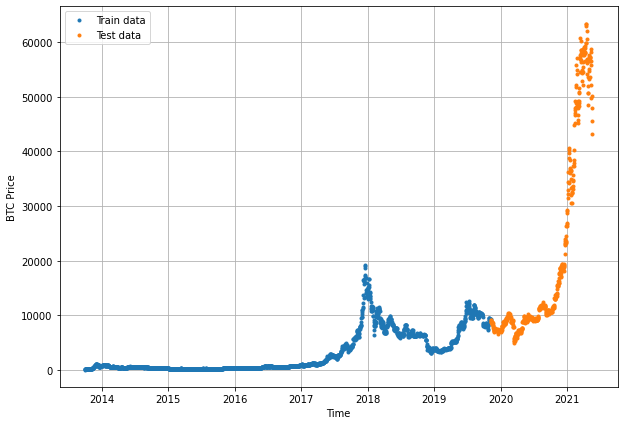

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")

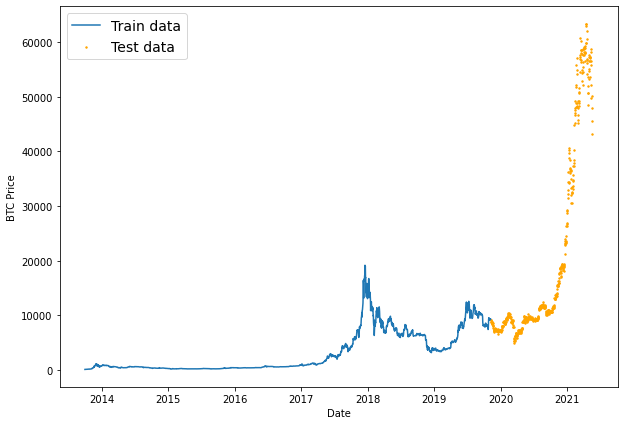

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.plot(x_train, y_train, label="Train data")
plt.scatter(x_test, y_test, s=2, label="Test data",color='orange')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

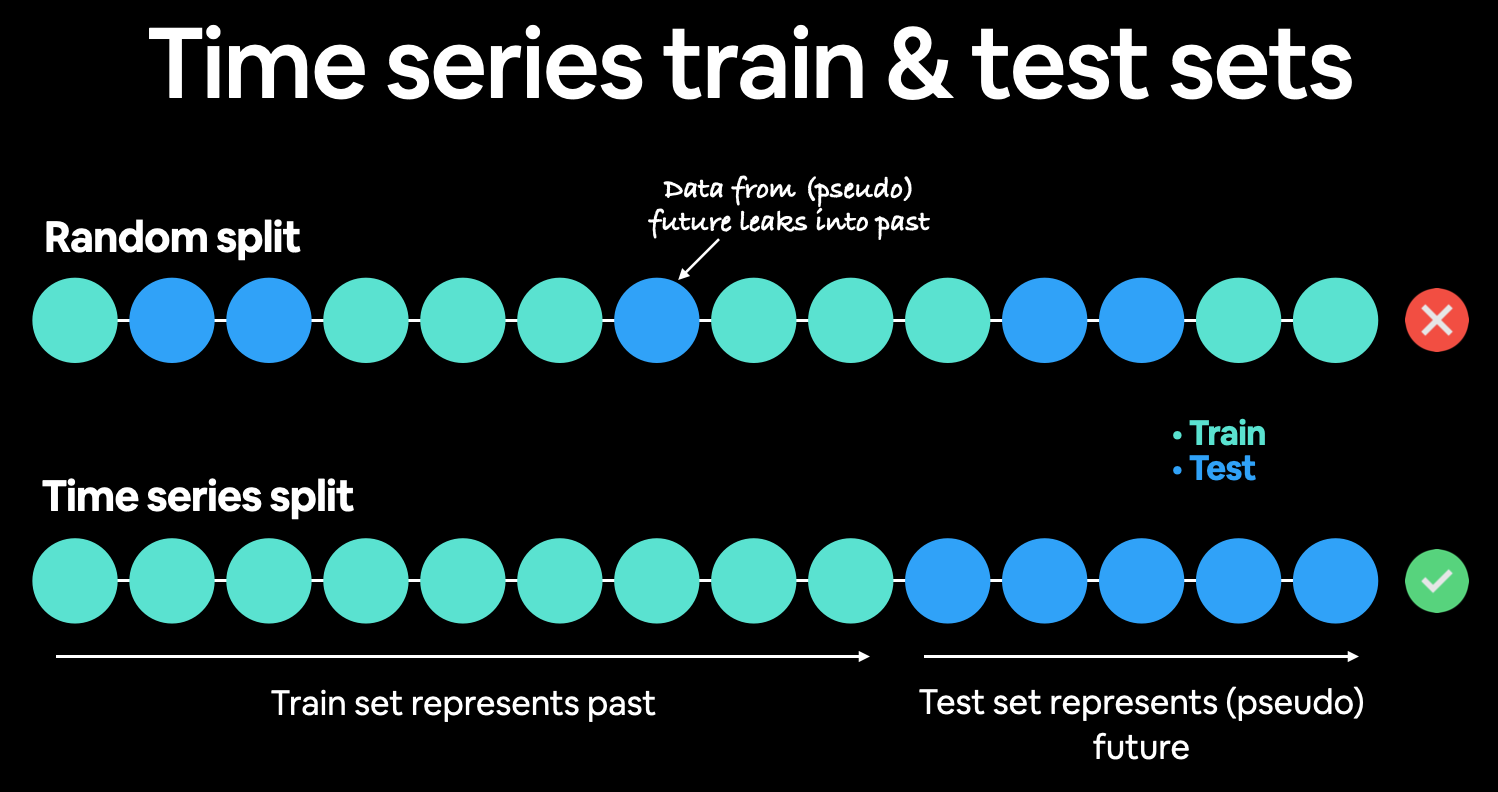
**Terms to Remember**
---
* **Horizon** = number of timesteps to predict into future.
* **window** = number of timesteps from past used to predict horizon.


**For example:** if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.
```
Now, how about those modelling experiments?
________________________________________________________________________________________________________________
Model Number	Model Type	                                       Horizon size	Window size	Extra data
_________________________________________________________________________________________________________________
0	Naive model (baseline)                                            NA                 NA            NA
_________________________________________________________________________________________________________________
1	Dense model         	                                          1                   7            NA
_________________________________________________________________________________________________________________
2	Same as 1                                                         1                  30            NA
_________________________________________________________________________________________________________________
3	Same as 1                                                         7                  30            NA
_________________________________________________________________________________________________________________
4	Conv1D                                                            1                  7             NA
_________________________________________________________________________________________________________________
5	LSTM                                                              1                  7             NA
_________________________________________________________________________________________________________________
6	Same as 1 (but with multivariate data)                            1                  7        Block reward size
_________________________________________________________________________________________________________________
7	N-BEATs Algorithm                                                 1                  7             NA
_________________________________________________________________________________________________________________
8	Ensemble (multiple models optimized on different loss functions)  1	              7             NA
_________________________________________________________________________________________________________________
9	Future prediction model (model to predict future values)	      1	              7             NA
_________________________________________________________________________________________________________________
10	Same as 1 (but with turkey 🦃 data introduced)                   1	              7	        NA
_________________________________________________________________________________________________________________
```


##Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:
$$\hat {y}_{t}=y_{t-1}$$

* The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep).


In [ ]:
# Create a naïve forecast
naive_forecast =y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10],naive_forecast[-10:] # View frist 10 and last 10-[45604.61575361, 43144.47129086]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

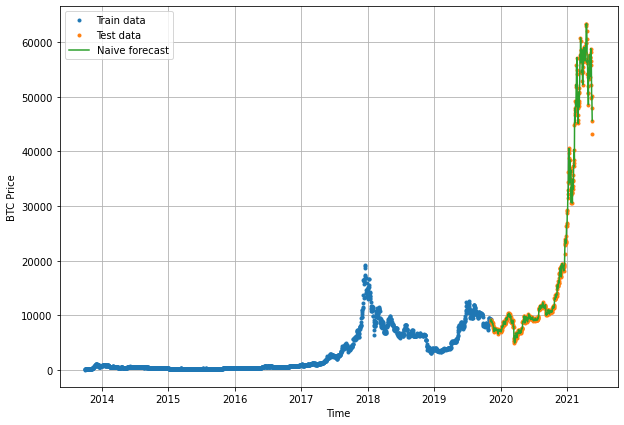

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")
plot_time_series(timesteps=x_test[1:],values=naive_forecast, format="-", label="Naive forecast");

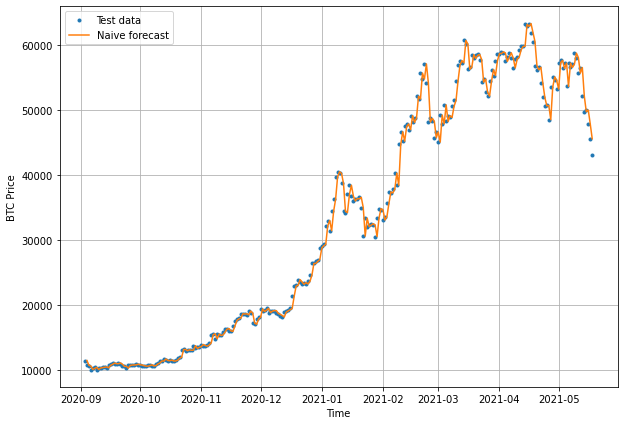

In [ ]:
## zoom little bit 
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=x_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

##Scale-dependent errors
* These are metrics which can be used to compare time series values and forecasts that are on the same scale.

**For example**, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

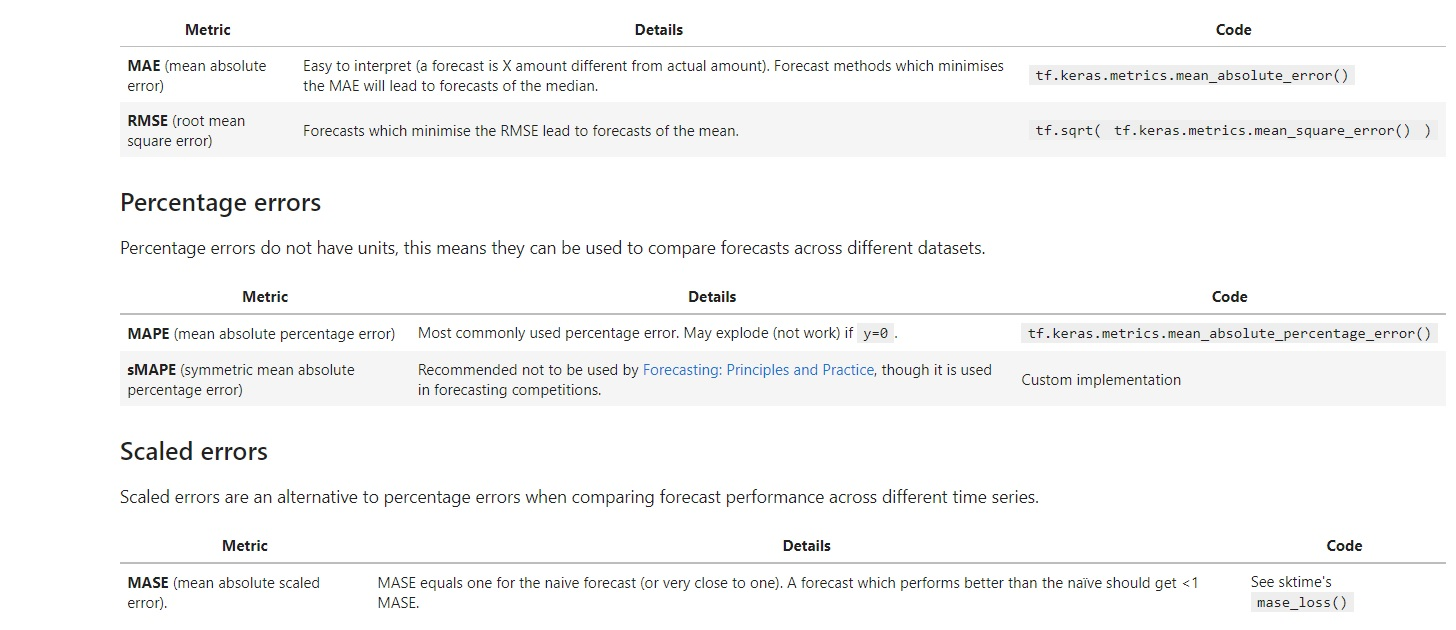


In [ ]:
# Mean Absolute scaled Error implementation:

def mean_absolute_scaled_error(y_true,y_pred):
    # function metric 1.1
    absolute=tf.abs(y_true,y_pred)              #gives absolute number |x| ie. no negative number
    mean_absol_error=tf.reduce_mean(absolute)   #gives only oone mean value
    
    # function metric 1.2
    mae_naive_no_season=tf.abs(y_true[1:],y_pred[:-1])      # y_test data from index position 1 to 557, from position 0 to 556 
    mae_naive_no_season=tf.reduce_mean(mae_naive_no_season) #gives only oone mean value

    return mean_absol_error/mae_naive_no_season

# checking :
mean_absolute_scaled_error(y_true=y_test[1:],y_pred=naive_forecast[:-1])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9989903220205395>

```
In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). 
Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.
```
Let's put each of our different evaluation metrics together into a function.

In [ ]:
def evaluate_metrics(y_true,y_pred):
    mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)                      # mean abs error
    mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)          # mean abs percentage error
    mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)                       # mean square error
    rmse=tf.sqrt(mse)                                                            # root mean square error
    mase=mean_absolute_scaled_error(y_true,y_pred)                               # def above

    dict_metrics={'Mean absolute Error':mae.numpy(),
                  'Mean absolute percentage error':mape.numpy(),
                  'Mean Square error':mse.numpy(),
                  'Root mean square error':rmse.numpy(),
                  'Mean_absolute_scaled_error':mase.numpy(),
    }
    return dict_metrics

In [ ]:
naive_results=evaluate_metrics(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'Mean Square error': 1147547.1250238959,
 'Mean absolute Error': 567.9802273457541,
 'Mean absolute percentage error': 2.516524929982267,
 'Mean_absolute_scaled_error': 0.9989903220205395,
 'Root mean square error': 1071.2362601330744}

In [ ]:
# print(f'we want to use{btc_price[:7]} to predict this:{btc_price[7]}')

In [ ]:
print(f'we want to use{btc_price[:7]} \n\nTo predict this:{btc_price.price[7]}')
print(f'\n\nto check the actual price of dated:2013-10-08 {btc_price[:8]}')

# Find average price of Bitcoin in test dataset
print(f'\n\n Average Price of the bitcoin is: {tf.reduce_mean(y_test).numpy()}')

we want to use                price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866
2013-10-06  120.65533
2013-10-07  121.79500 

To predict this:123.033


to check the actual price of dated:2013-10-08                 price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866
2013-10-06  120.65533
2013-10-07  121.79500
2013-10-08  123.03300


 Average Price of the bitcoin is: 20056.632963737222


##Format Data Part 2: Windowing dataset
**Windowing** is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

Window for one week (univariate time series)

* [0, 1, 2, 3, 4, 5, 6] -> [7]
* [1, 2, 3, 4, 5, 6, 7] -> [8]
* [2, 3, 4, 5, 6, 7, 8] -> [9]

Or for the price of Bitcoin, it'd look like:

Window for one week with the target of predicting the next day (Bitcoin prices)

* [123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
* [125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
* [108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]

In [ ]:
# setting the horizon and window_size
HORIZON=1       # number of timesteps to predict into future.
WINDOW_SIZE=7   # number of timesteps from past used to predict horizon.


In [ ]:
# create function to label window data:
def get_labelled_window(x,horizon=HORIZON):
    return x[:,:-horizon] , x[:, -horizon:]

In [ ]:
## testing get_labelled_window:
test_window,test_label=get_labelled_window(tf.expand_dims(tf.range(8),axis=0))
                      #>>get_labelled_window(8)
                      #>>8[:,:-1] # 8[axis0,axis1]

print(f'window:{tf.squeeze(test_window).numpy()} \n-> Label:{tf.squeeze(test_label).numpy()}')


window:[0 1 2 3 4 5 6] 
-> Label:7


### Let's write a function which:

* Creates a window step of specific window size, for example: [[0, 1, 2, 3, 4, 5, 6, 7]]

* Uses NumPy indexing to create a 2D of multiple window steps, for example:

        [[0, 1, 2, 3, 4, 5, 6, 7],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [2, 3, 4, 5, 6, 7, 8, 9]]

* Uses the 2D array of multuple window steps to index on a target series
Uses the get_labelled_windows() 
* function we created above to turn the window steps into windows with a specified horizon.


📖 Resource: The function created below has been adapted from Syafiq Kamarul Azman's article [Fast and Robust Sliding Window Vectorization with NumPy.](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)

In [ ]:
## Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  # def get_labelled_window(x,horizon=HORIZON):
  # return x[:,:-horizon] , x[:, -horizon:]
  windows, labels = get_labelled_window(windowed_array,horizon=HORIZON)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels),full_labels.shape,full_windows.shape

(2780, 2780, (2780, 1), (2780, 7))

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window:{full_windows[i-3]}\n -> Label: {full_labels[i-3]}")

Window:[58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676]
 -> Label: [47885.62525472]
Window:[58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472]
 -> Label: [45604.61575361]
Window:[55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361]
 -> Label: [43144.47129086]


### Make the Train and Test Split:


In [ ]:
def make_train_test_split(window,label): # window ,label= (full_windows, full_labels)
    split_size = int(len(window) *(0.8))

    train_window=window[:split_size]
    train_label=label[:split_size]
    test_window=window[split_size:]
    test_label=label[split_size:]
    return train_window,train_label,test_window,test_label

In [ ]:
train_window, train_label,test_window, test_label = make_train_test_split(full_windows, full_labels)
len(train_window), len(test_window), len(train_label), len(test_label)

(2224, 556, 2224, 556)

In [ ]:
train_window.shape, train_label.shape,test_window.shape, test_label.shape

((2224, 7), (2224, 1), (556, 7), (556, 1))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_label[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

### Make a modelling checkpoint:


In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model 1: Dense model (window = 7, horizon = 1)

We're going to start by keeping it simple, model_1 will have:

* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [ ]:
# creating the model
tf.random.set_seed(21)
model_1=tf.keras.Sequential([
                              tf.keras.layers.Dense(128,activation='relu'),
                              tf.keras.layers.Dense(HORIZON,activation='linear')],# linear activation is the same as having no activation      
                              name='sequential_model_1_dense')


#compiling the model:
model_1.compile(loss=tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error'),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

## fitting the model_1:
model_1.fit(x=train_window,
            y=train_label,
            epochs=100,
            batch_size=32,
            validation_data=(test_window,test_label),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
70/70 [==============================] - 4s 17ms/step - loss: 1102.1669 - mae: 1102.1669 - val_loss: 917.0550 - val_mae: 917.0550
Epoch 2/100
70/70 [==============================] - 1s 10ms/step - loss: 164.7449 - mae: 164.7449 - val_loss: 856.6789 - val_mae: 856.6789
Epoch 3/100
70/70 [==============================] - 1s 11ms/step - loss: 151.7862 - mae: 151.7862 - val_loss: 836.6741 - val_mae: 836.6741
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 149.4052 - mae: 149.4052 - val_loss: 922.8403 - val_mae: 922.8403
Epoch 5/100
70/70 [==============================] - 1s 10ms/step - loss: 160.8706 - mae: 160.8706 - val_loss: 743.6210 - val_mae: 743.6210
Epoch 6/100
70/70 [==============================] - 1s 11ms/step - loss: 145.0870 - mae: 145.0870 - val_loss: 732.3309 - val_mae: 732.3309
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 143.4184 - mae: 143.4184 - val_loss: 746.1183 - val_mae: 746.1183
Epoch 8/100
70/70 [=

In [ ]:
## evaluate the model_1 on test data:
model_1.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 616.5383 - mae: 616.5383


[616.5382690429688, 616.5382690429688]

In [ ]:
## loading the best performing metric of model_1 and evaluate on test_data:
model_1=tf.keras.models.load_model('/content/model_experiments/sequential_model_1_dense')
model_1.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 562.2295 - mae: 562.2295


[562.2294921875, 562.2294921875]

###Making forecasts with a model (on the test dataset)

In [ ]:
model_1_forecast=model_1.predict(test_window)
model_1_preds=tf.squeeze(model_1_forecast)

In [ ]:
model_1_preds[:10],model_1_preds.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8857.75 , 8800.67 , 9057.081, 8799.272, 8768.661, 8745.174,
        8692.027, 8546.078, 8472.11 , 8546.11 ], dtype=float32)>,
 TensorShape([556]))

In [ ]:
# Evaluate metrics:
model_1_results = evaluate_metrics(y_true=tf.squeeze(test_label), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'Mean Square error': 1152402.0,
 'Mean absolute Error': 562.22955,
 'Mean absolute percentage error': 2.5050695,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1073.4999}

In [ ]:
naive_results

{'Mean Square error': 1147547.1250238959,
 'Mean absolute Error': 567.9802273457541,
 'Mean absolute percentage error': 2.516524929982267,
 'Mean_absolute_scaled_error': 0.9989903220205395,
 'Root mean square error': 1071.2362601330744}

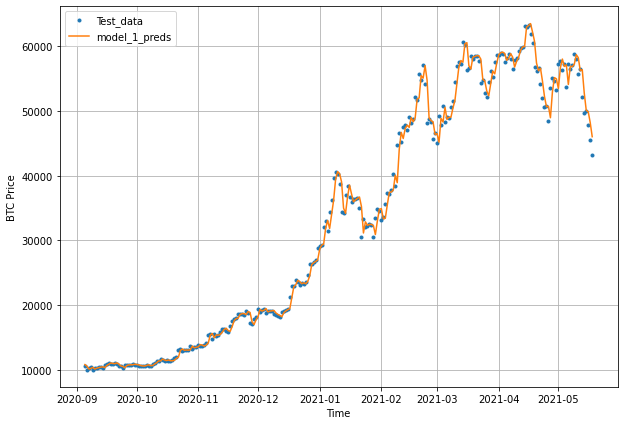

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=x_test[-len(test_window):], values=test_label[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=x_test[-len(test_window):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON=1
WINDOW=30

full_windows,full_label=make_windows(prices,horizon=HORIZON,window_size=WINDOW)
len(full_windows),len(full_label),full_windows.shape,full_label.shape


(2757, 2757, (2757, 30), (2757, 1))

In [ ]:
#Make the Train and Test Split:
train_window,train_label,test_window,test_label=make_train_test_split(full_windows,full_label)

len(train_window),len(train_label),len(test_window),len(test_label)

(2205, 2205, 552, 552)

In [ ]:
## checking the shape
train_window.shape,train_label.shape,test_window.shape,test_label.shape

((2205, 30), (2205, 1), (552, 30), (552, 1))

In [ ]:
## creating model_2:

model_2=tf.keras.Sequential([
                             tf.keras.layers.Dense(128,activation='relu'),
                             tf.keras.layers.Dense(HORIZON)])

#compiling the model:
model_2.compile(loss=tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error'),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

## fitting the model_1:
model_2.fit(x=train_window,
            y=train_label,
            epochs=100,
            batch_size=32,
            validation_data=(test_window,test_label),
            verbose=0,
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:tensorflow:Assets written to: model_experiments/sequential/assets
INFO:t

In [ ]:
# Evaluate the model:
model_2.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 592.1669 - mae: 592.1669


[592.1669311523438, 592.1669311523438]

In [ ]:
# calling best epoch:loading the best performing metric of model_2 and evaluate on test_data:
model_2=tf.keras.models.load_model('model_experiments/sequential')
model_2.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 571.7744 - mae: 571.7744


[571.7744140625, 571.7744140625]

In [ ]:
# predicting he model_2:
model_2_forecast= model_2.predict(test_window)
model_2_forecast[:10],len(model_2_forecast),model_2_forecast.shape

(array([[8885.564 ],
        [8876.63  ],
        [8777.551 ],
        [8630.58  ],
        [8503.586 ],
        [8435.533 ],
        [8194.29  ],
        [8198.599 ],
        [8238.148 ],
        [7755.9976]], dtype=float32), 552, (552, 1))

In [ ]:
# making it 1d:
model_2_preds=tf.squeeze(model_2_forecast)
model_2_preds.shape,model_2_preds.ndim

(TensorShape([552]), 1)

In [ ]:
model_2_results=evaluate_metrics(tf.squeeze(test_label),model_2_preds)

In [ ]:
model_2_results

{'Mean Square error': 1155495.2,
 'Mean absolute Error': 571.7743,
 'Mean absolute percentage error': 2.6287785,
 'Mean_absolute_scaled_error': 0.998973138835791,
 'Root mean square error': 1074.9397}

In [ ]:
model_1_results

{'Mean Square error': 1152402.0,
 'Mean absolute Error': 562.22955,
 'Mean absolute percentage error': 2.5050695,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1073.4999}

In [ ]:
naive_results

{'Mean Square error': 1147547.1250238959,
 'Mean absolute Error': 567.9802273457541,
 'Mean absolute percentage error': 2.516524929982267,
 'Mean_absolute_scaled_error': 0.9989903220205395,
 'Root mean square error': 1071.2362601330744}

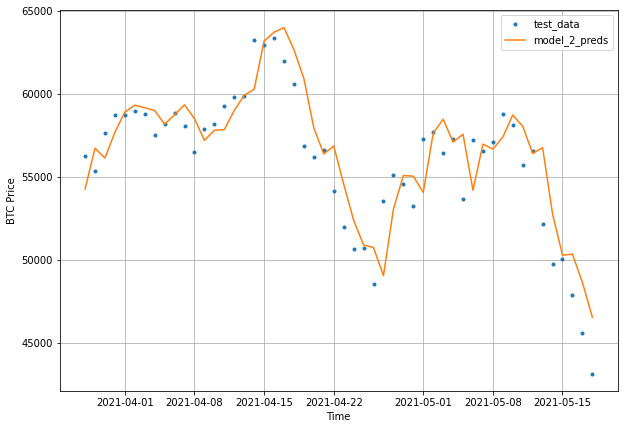

In [ ]:
offset =500 #@param{type:"slider" ,min:300,max:500,step:100}
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=x_test[-len(test_window):], values=test_label[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=x_test[-len(test_window):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Dense (window = 30, horizon = 7)
Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the HORIZON and WINDOW_SIZE variables and create windowed data.


In [ ]:
len(prices)

2787

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
#Make the Train and Test Split:
train_window, train_label,test_window, test_label = make_train_test_split(full_windows, full_labels)
len(train_window), len(test_window), len(train_label), len(test_label)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(21)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_window,
            train_label,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_window, test_label),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2218.5801INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 37ms/step - loss: 2212.4626 - val_loss: 3949.9011
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 591.2771INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 591.2771 - val_loss: 2563.3237
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 396.8143INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 61ms/step - loss: 445.8616 - val_loss: 2114.8301
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 410.3049INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 410.3049 - val_loss: 2081.3838
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 389.3148INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 385.3727 - val_loss: 2031.0367
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 364.5644INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 364.5644 - val_loss: 1847.5265
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 344.9314INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 344.4782 - val_loss: 1776.6523
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 329.2917INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 329.2917 - val_loss: 1758.2736
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 314.6843INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 31ms/step - loss: 314.6843 - val_loss: 1612.1814
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 304.1418 - val_loss: 1705.1962
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 295.6885INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 295.6885 - val_loss: 1611.8198
Epoch 12/100
18/18 [==============================] - ETA: 0s - loss: 286.1587INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 286.1587 - val_loss: 1492.9233
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 279.4460 - val_loss: 1551.7490
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 274.2728INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 31ms/step - loss: 276.2128 - val_loss: 1442.6152
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 270.2818INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 268.9949 - val_loss: 1408.1726
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 264.0067INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 266.0069 - val_loss: 1403.6747
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 263.7968 - val_loss: 1445.0424
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 262.2226 - val_loss: 1418.9059
Epoch 19/100
17/18 [===========================>..] - ETA: 0s - loss: 256.8671INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 256.5773 - val_loss: 1369.9889
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 254.1168 - val_loss: 1380.4723
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 256.6022 - val_loss: 1455.8292
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 254.3810 - val_loss: 1385.7507
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 189.0012INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 249.2729 - val_loss: 1368.4777
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 249.9520INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 31ms/step - loss: 249.9520 - val_loss: 1344.2776
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 250.4645 - val_loss: 1460.8495
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 247.4587 - val_loss: 1369.1050
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 245.9351 - val_loss: 1409.4818
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 245.8150 - val_loss: 1494.6210
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 255.8199 - val_loss: 1349.1890
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 240.1209 - val_loss: 1386.8362
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 240.4356INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 240.4356 - val_loss: 1328.1986
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 251.3878 - val_loss: 1386.2957
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 253.0362 - val_loss: 1385.2634
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 240.4998 - val_loss: 1346.2412
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 240.3999 - val_loss: 1337.7838
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 234.9707INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 234.9707 - val_loss: 1323.6980
Epoch 37/100
18/18 [==============================] - ETA: 0s - loss: 233.4797INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 31ms/step - loss: 233.4797 - val_loss: 1316.2323
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 236.2311 - val_loss: 1354.3195
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 235.1571INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 236.5443 - val_loss: 1297.2716
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 252.9878 - val_loss: 1363.6738
Epoch 41/100
18/18 [==============================] - ETA: 0s - loss: 234.7100INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 31ms/step - loss: 234.7100 - val_loss: 1285.6353
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 241.7818 - val_loss: 1387.0983
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 236.2475 - val_loss: 1298.1597
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 232.9077 - val_loss: 1352.7261
Epoch 45/100
18/18 [==============================] - ETA: 0s - loss: 234.7251INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 234.7251 - val_loss: 1278.3831
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 236.1664 - val_loss: 1653.2737
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 241.5617 - val_loss: 1344.1356
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 234.1513 - val_loss: 1287.0597
Epoch 49/100
18/18 [==============================] - ETA: 0s - loss: 232.0276INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 232.0276 - val_loss: 1256.9401
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 242.8218 - val_loss: 1272.3721
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 234.4721 - val_loss: 1287.0524
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 233.3515 - val_loss: 1267.9176
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 229.7030 - val_loss: 1264.4664
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 230.7995 - val_loss: 1538.5964
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 236.6476 - val_loss: 1346.2233
Epoch 56/100
14/18 [======================>.......] - ETA: 0s - loss: 226.3492INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 236.0209 - val_loss: 1249.5928
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 232.0819 - val_loss: 1294.8967
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 228.4668 - val_loss: 1305.7214
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 231.9270 - val_loss: 1296.2064
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 227.4003 - val_loss: 1250.5004
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 231.5140 - val_loss: 1335.4366
Epoch 62/100
18/18 [==============================] - ETA: 0s - loss: 228.1641INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 39ms/step - loss: 228.1641 - val_loss: 1240.4642
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 227.8945 - val_loss: 1323.3187
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 228.4432 - val_loss: 1269.1982
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 226.0138 - val_loss: 1273.7877
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 224.4651 - val_loss: 1452.2435
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 239.1873 - val_loss: 1343.5913
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 227.3596 - val_loss: 1285.2499
Epoch 69/100
18/18 [==============================] - ETA: 0s - loss: 230.9834INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 32ms/step - loss: 230.9834 - val_loss: 1232.8844
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 227.5116 - val_loss: 1315.4399
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 225.9054 - val_loss: 1292.4962
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 224.1246 - val_loss: 1418.6274
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 225.4743 - val_loss: 1247.3612
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 225.6764 - val_loss: 1332.7151
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 225.3701 - val_loss: 1300.3829
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 225.8633 - val_loss: 1255.6827
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 230.2261 - val_loss: 1261.7257
Epoch 78/100
18/18 [==============================] - 0s 5ms/step -

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 222.5566 - val_loss: 1227.3895
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 222.1001 - val_loss: 1255.3870
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 221.9695 - val_loss: 1239.4109
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 222.0653 - val_loss: 1271.1216
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 220.0476 - val_loss: 1236.9944
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 222.5209 - val_loss: 1264.1534
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 219.5551 - val_loss: 1227.8181
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 227.3428 - val_loss: 1246.5515
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 225.0285 - val_loss: 1286.0952


In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_window, test_label)

18/18 [==============================] - 0s 2ms/step - loss: 1286.0952


1286.09521484375

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_window, test_label)

18/18 [==============================] - 0s 3ms/step - loss: 1227.3895


1227.3895263671875

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_forecast = model_3.predict(test_window)
model_3_preds  =tf.squeeze(model_3_forecast)                        
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9117.364 , 9460.634 , 9321.255 , 9281.925 , 9345.75  , 9622.651 ,
        9568.457 ],
       [8853.839 , 8903.544 , 9133.21  , 8944.877 , 9113.087 , 9266.744 ,
        9212.5   ],
       [8891.523 , 8671.742 , 9125.991 , 8871.591 , 8957.328 , 9302.835 ,
        9183.281 ],
       [9094.789 , 8916.384 , 9227.4795, 8907.369 , 9179.29  , 9309.737 ,
        9252.507 ],
       [8890.761 , 8828.359 , 9090.927 , 8863.292 , 9106.847 , 9190.91  ,
        8933.843 ]], dtype=float32)>

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  dict_metrics={'Mean absolute Error':mae.numpy(),
                  'Mean absolute percentage error':mape.numpy(),
                  'Mean Square error':mse.numpy(),
                  'Root mean square error':rmse.numpy(),
                  'Mean_absolute_scaled_error':mase.numpy()}
  return dict_metrics

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_3_preds)
model_3_results

{'Mean Square error': 5351875.5,
 'Mean absolute Error': 1227.3895,
 'Mean absolute percentage error': 5.4707775,
 'Mean_absolute_scaled_error': 0.9989826,
 'Root mean square error': 1413.5162}

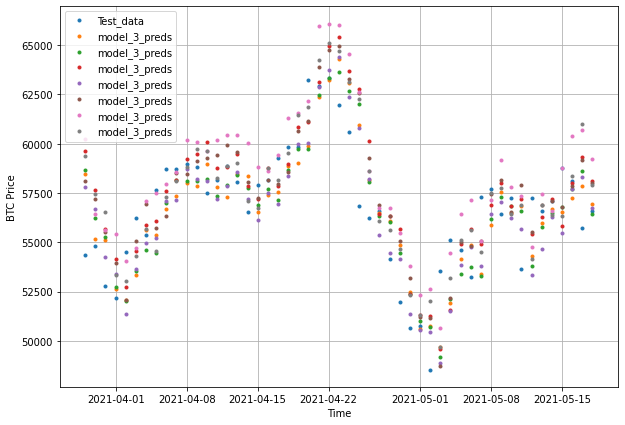

In [ ]:
## model_3 predictions:plot

offset =500 #@param{type:"slider" ,min:300,max:500,step:100}
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_test[-len(test_window):], values=test_label[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=x_test[-len(test_window):], values=model_3_preds, start=offset, label="model_3_preds")

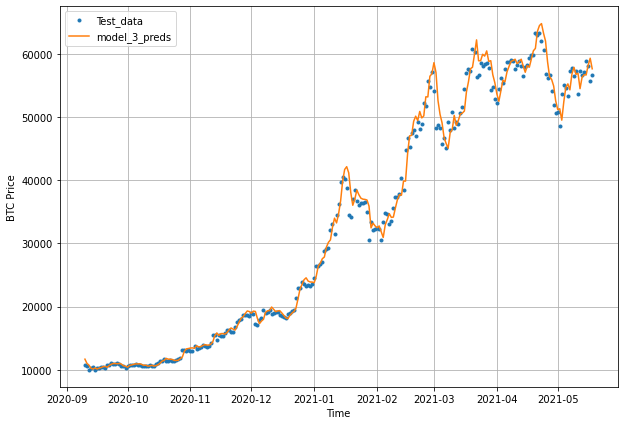

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)

plot_time_series(timesteps=x_test[-len(test_window):], 
                    values=test_label[:, 0], 
                         start=offset, 
                             label="Test_data")

plot_time_series(timesteps=x_test[-len(test_window):], 
                    values=tf.reduce_mean(model_3_preds, axis=1), 
                        format="-",
                            start=offset, 
                                label="model_3_preds")

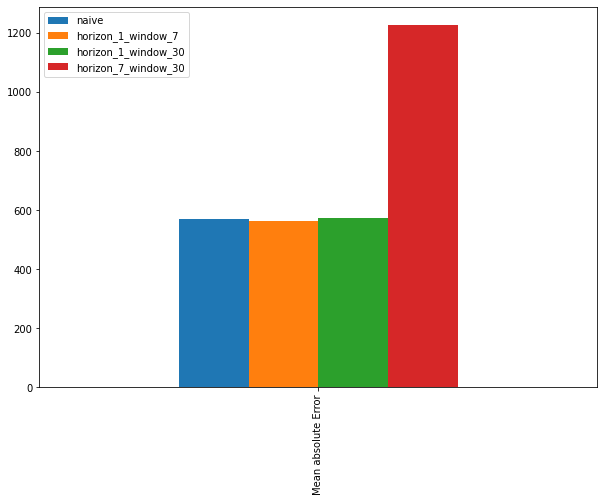

In [ ]:
pd.DataFrame({"naive": naive_results["Mean absolute Error"], 
              "horizon_1_window_7": model_1_results["Mean absolute Error"], 
              "horizon_1_window_30": model_2_results["Mean absolute Error"], 
              "horizon_7_window_30": model_3_results["Mean absolute Error"]},
             
                           index=["Mean absolute Error"]).plot(figsize=(10, 7), kind="bar");

**The dense model with a horizon of 1 and a window size of 7 looks to be performing best among all.** 

Because of this, let's use HORIZON=1 and WINDOW_SIZE=7 for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).
```
🔑 Note: You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data.
If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep).
In other words, today's value is probably pretty close to yesterday's value. 
Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.
```

###Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_window,  train_label, test_window,test_label = make_train_test_split(full_windows, full_labels)
len(train_window), len(test_window), len(train_label), len(test_label)

(2224, 556, 2224, 556)

In [ ]:
## checking the shape:
train_window.shape,train_label.shape, test_window.shape,test_label.shape 

((2224, 7), (2224, 1), (556, 7), (556, 1))

In [ ]:
# Check data sample shapes
train_window[0].shape # returns (WINDOW_SIZE, )

(7,)

In [ ]:
## Reshaping the layer  using the lambda function:
x=tf.constant(train_window[0])
x

expand_dims=tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1)) #wraps arbitrary expressions as a Layer object.

In [ ]:
## testing the lambda function:

print(f'original shape: {x.shape}')
print(f'expand shape: {expand_dims(x).shape}')

original shape: (7,)
expand shape: (7, 1)


In [ ]:
# layering 
tf.random.set_seed(21)
model_4 = tf.keras.Sequential([
# Create Lambda layer to reshape inputs, without this layer, the model will error
                            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),# resize the inputs to adjust for window size / Conv1D 3D input requirements
                             tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                             tf.keras.layers.Dense(HORIZON)
                             ],name="model_4_conv1D")


# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


In [ ]:
# Fit model
model_4.fit(train_window,
            train_label,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_window, test_label),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_window, test_label)

18/18 [==============================] - 0s 4ms/step - loss: 568.5826


568.5826416015625

In [ ]:
model_4_forecast=model_4.predict(test_window)
model_4_pred=tf.squeeze(model_4_forecast)
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8901.348, 8797.189, 8995.039, 8811.717, 8770.433, 8719.014,
       8703.128, 8550.813, 8465.028, 8525.281], dtype=float32)>

In [ ]:
# Get model_3 results aggregated to single values
model_4_results = evaluate_metrics(y_true=tf.squeeze(test_label),
                                 y_pred=model_4_pred)
model_4_results

{'Mean Square error': 1178063.1,
 'Mean absolute Error': 568.58264,
 'Mean absolute percentage error': 2.5675688,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1085.3862}

###Model 5: RNN (LSTM):

In [ ]:
tf.random.set_seed(21)
# Let's build an LSTM model with the Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))

# expand input dimension to be compatible with LSTM
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 

# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = tf.keras.layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing:
model_5.fit(train_window,
            train_label,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_window, test_label),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_window, test_label)

18/18 [==============================] - 0s 3ms/step - loss: 571.5595


571.5595092773438

In [ ]:
model_5_forecast=model_5.predict(test_window)
model_5_pred=tf.squeeze(model_5_forecast)
model_5_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8896.535, 8791.661, 8993.415, 8788.305, 8750.005, 8734.554,
       8683.032, 8540.653, 8462.285, 8517.36 ], dtype=float32)>

In [ ]:
# Get model_3 results aggregated to single values
model_5_results = evaluate_metrics(y_true=tf.squeeze(test_label),
                                 y_pred=model_5_pred)
model_5_results

{'Mean Square error': 1183599.5,
 'Mean absolute Error': 571.55945,
 'Mean absolute percentage error': 2.5950646,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1087.9336}

In [ ]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1_results

{'Mean Square error': 1152402.0,
 'Mean absolute Error': 562.22955,
 'Mean absolute percentage error': 2.5050695,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1073.4999}

In [ ]:
model_5_results

{'Mean Square error': 1183599.5,
 'Mean absolute Error': 571.55945,
 'Mean absolute percentage error': 2.5950646,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1087.9336}

##Make a multivariate time series:
* The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

* At its inception, the Bitcoin block reward size was 50.
* But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.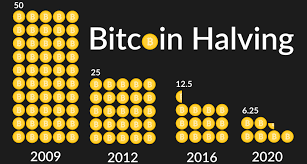

🔑 Note: Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [ ]:
btc_price[:3]

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483


In [ ]:
## lets add the btc halving event to our dataset:

block_reward_1=50       #dated 3.1.09
block_reward_2=25       #dated 28.11.12
block_reward_3=12.5     #dated 9.7.16
block_reward_4=6.5      #dated 18.6.20

#Block reward dates: 
#fromat(YYYY-MM-DD)
block_reward_2_datetime=np.datetime64("2012-11-28")    
block_reward_3_datetime= np.datetime64("2016-07-09")     
block_reward_4_datetime=np.datetime64('2020-06-12')

In [ ]:
## creating the range of days where specific block reward value should be:

block_reward_2_days=(block_reward_3_datetime - btc_price.index[0]).days
block_reward_3_days=(block_reward_4_datetime - btc_price.index[0]).days

block_reward_2_days,block_reward_3_days

(1012, 2446)

In [ ]:
## add in block reward column:
btc_price_block=btc_price.copy()
btc_price_block['block_reward']=None

btc_price_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,None
2013-10-02,125.45500,None
2013-10-03,108.58483,None
2013-10-04,118.67466,None
2013-10-05,121.33866,None


In [ ]:
## adding the block reward values as a future to our dataframe:
btc_price_block.iloc[:block_reward_2_days,-1]=block_reward_2
btc_price_block.iloc[block_reward_2_days:block_reward_3_days,-1]=block_reward_3
btc_price_block.iloc[block_reward_3_days:,-1]=block_reward_4

In [ ]:
btc_price_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
btc_price_block.tail()

,price,block_reward
Date,,
2021-05-14,49764.132082,6.5
2021-05-15,50032.693137,6.5
2021-05-16,47885.625255,6.5
2021-05-17,45604.615754,6.5
2021-05-18,43144.471291,6.5


```
class sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)[source]

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually,such that it is in the given range
on the training set,e.g. between zero and one.
```

In [ ]:
## plot the block reward v/s price over time:

from sklearn.preprocessing import minmax_scale

scaled_price_block_df=pd.DataFrame(minmax_scale(btc_price_block[['price','block_reward']]),
                                   columns=btc_price_block.columns,
                                   index=btc_price_block.index)


```
## lets add the btc halving event to our dataset:

block_reward_3=12.5     #dated 9.7.16
block_reward_4=6.5      #dated 18.6.20

#Block reward dates: 
#fromat(YYYY-MM-DD)   
block_reward_3_datetime= np.datetime64("2016-07-09")     
block_reward_4_datetime=np.datetime64('2020-06-12')
```

## Model 6: Dense (multivariate time series)
To keep things simple, let's the model_1 architecture and use it to train and make predictions on our multivariate time series data.

By replicating the model_1 architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [ ]:
# hyperperameters setting:
HORIZON=1
WINDOW_SIZE=7

## Make a copy of bitcoin historical data with block reward feature:
btc_price_windowed=btc_price_block.copy()

## add window column:
for i in range(WINDOW_SIZE): ## loop_shift value for each window
    btc_price_windowed[f'price+({i+1})'] = btc_price_windowed['price'].shift(i+1)


[Go through what is shift function](https://towardsdatascience.com/5-elegant-python-pandas-functions-a4bf395ebef4)

In [ ]:
btc_price_windowed.head(8)

,price,block_reward,price+(1),price+(2),price+(3),price+(4),price+(5),price+(6),price+(7)
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499


In [ ]:
btc_price_windowed.tail()

,price,block_reward,price+(1),price+(2),price+(3),price+(4),price+(5),price+(6),price+(7)
Date,,,,,,,,,
2021-05-14,49764.132082,6.5,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.5,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.5,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.5,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.5,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
dfl = btc_price.nlargest(3,'price')## top 3 largest values of btc
print(dfl)

                   price
Date                    
2021-04-16  63346.789035
2021-04-14  63223.884391
2021-04-15  62926.557176


```
Now that we've got a windowed dataset, let's separate features (X) from labels (y).

Remember in our windowed dataset, we're trying to use the previous WINDOW_SIZE steps to predict HORIZON steps.

Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
We'll also remove the NaN values using pandas dropna() method, this equivalent to starting our
windowing function at sample 0 (the first sample) + WINDOW_SIZE.
```

In [ ]:
## droping colummn having NaN:
clean_btc_data= btc_price_windowed.dropna()


## now from price column from clean_btc_data dataset
x=clean_btc_data.drop('price',axis=1).astype(np.float32)
## now drop every price+ col except price column from clean_btc_data dataset
y=clean_btc_data["price"].astype(np.float32)

x.head(3)

,block_reward,price+(1),price+(2),price+(3),price+(4),price+(5),price+(6),price+(7)
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831


In [ ]:
y.head(3)

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
Name: price, dtype: float32

In [ ]:
## make train ,test split data:

split_size=int(len(x)*0.8)
x_train,y_train=x[:split_size],y[:split_size]
x_test,y_test=x[split_size:],y[split_size:]

len(x_train),len(y_train),len(x_test),len(y_test)


(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(21)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
                                tf.keras.layers.Dense(128, activation="relu"),
                                # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
                                tf.keras.layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(x_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 566.3172


566.3171997070312

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8849.35 , 8775.411, 9026.745, 8786.997, 8738.02 , 8715.713,
       8691.854, 8504.535, 8460.043, 8518.931], dtype=float32)>

In [ ]:
# Evaluate preds
model_6_results = evaluate_metrics(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'Mean Square error': 1161493.5,
 'Mean absolute Error': 566.31726,
 'Mean absolute percentage error': 2.5519092,
 'Mean_absolute_scaled_error': 0.99898815,
 'Root mean square error': 1077.7262}

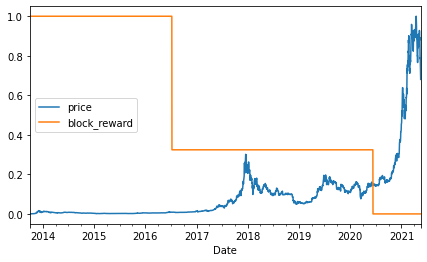

In [ ]:
# plot:
scaled_price_block_df.plot(figsize=(7,4));

# Model 7: N-BEATS algorithm
###create NBeatsBlock custom layer: tf.keras.layers.Layer
* This is the class from which all layers inherit.
* A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors.
* It involves computation, defined in the call() method, and a state (weight variables). State can be created in various places, at the convenience of the subclass implementer:

* in __init__();
* in the optional build() method, which is invoked by the first __call__() to the layer, and supplies the shape(s) of the input(s), which may not have been known at initialization time;
* in the first invocation of call(), with some caveats below.

```
#The self in keyword  is used to all the instances in a class. By using the self keyword, one
 can easily access all the instances defined within a class, including its methods and attributes. 
                        __init__ is one of the reserved methods in Python. 
```

**Using the same hyperparameters as the paper which can be found in Appendix D of the N-BEATS paper**
Doing this will give us an opportunity to practice:

*  Creating a custom layer for the NBeatsBlock by subclassing tf.keras.layers.Layer.

* Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)

*  Implementing a custom architecture using the Functional API
Finding a paper related to our problem and seeing how it goes


🔑 Note: As you'll see in the paper, the authors state “N-BEATS is implemented and trained in TensorFlow”, that's what we'll be doing too!

Building and testing an N-BEATS block layer


In [ ]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs): # the call method is what runs when the layer is called 
        x = inputs 
        for layer in self.hidden: # pass inputs through each hidden layer 
            x = layer(x)
        theta = self.theta_layer(x) 
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

     ## for saving the custom layer:
    def get_config(self):
        config =super().get_config()
        config.update({'input_size':self.input_size,
                    "theta_size":self.theta_size,
                    "horizon":self.horizon,
                    "n_layers":self.n_layers,
                    "n_neurons":self.n_neurons})
        return config


Setting up the ```NBeatsBlock``` custom layer we see:

* The class inherits from``` tf.keras.layers.Layer ```(this gives it all of the methods assosciated with tf.keras.layers.Layer)
* The constructor``` (def __init__(...)) ```takes all of the layer hyperparameters as well as the **kwargs argument
   * The **kwargs argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, ```input_shape```,``` trainable``` and``` name```


* In the constructor, the block architecture layers are created:
   * The hidden layers are created as a stack of fully connected with``` n_nuerons``` hidden units layers with ReLU activation
   * The theta layer uses ```theta_size``` hidden units as well as linear activation
* The ```call()``` method is what is run when the layer is called:
   * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
   * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: ```input_size```) and ```forecast``` (forward predictions, shape:``` horizon```) are returned

In [ ]:
## setup dummy NBeatBlock layer to represent input and output:
WINDOW_SIZE=7
HORIZON=1
dummy_nbeats_block_layer=NBeatsBlock(input_size=WINDOW_SIZE,
                                    theta_size=WINDOW_SIZE+HORIZON,
                                     horizon=HORIZON,
                                     n_neurons=128,
                                     n_layers=4)



In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.4606623  -0.05882028  0.6292285   0.04442921  0.30256367  0.4070028
 -0.12103337]
Forecast: -0.029765456914901733


In [ ]:
#preaparing the data for the n_Beats using tf.data:
# creating the N-beat Data Input:
btc_price.head(4)

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466


In [ ]:
btc_price_nbeats=btc_price.copy()
#btc_price_nbeats.head(4)

for i in range(WINDOW_SIZE):
    btc_price_nbeats[f'price+{i+1}']=btc_price_nbeats['price'].shift(i+1)

btc_price_nbeats.head(8)


,price,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499


In [ ]:
## droping the NAN and prepaaring the train and test data:

x=btc_price_nbeats.dropna().drop('price',axis=1)
y=btc_price_nbeats.dropna()['price']

#spliting the data:
split_data=int(len(x)*0.80)
x_train,y_train= x[:split_data],y[:split_data]
x_test,y_test=   x[split_data:],y[split_data:]

len(x_train),len(y_train),len(x_test),len(y_test)

(2224, 2224, 556, 556)

In [ ]:
## dataset format (data API)
BATCH_SIZE=1024
train_feature_dataset=tf.data.Dataset.from_tensor_slices(x_train)
train_label_dataset=tf.data.Dataset.from_tensor_slices(y_train)
train_dataset=tf.data.Dataset.zip((train_feature_dataset,train_label_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_feature_dataset=tf.data.Dataset.from_tensor_slices(x_test)
test_label_dataset=tf.data.Dataset.from_tensor_slices(y_test)
test_dataset=tf.data.Dataset.zip((test_feature_dataset,test_label_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

###Getting ready for residual connections
*  Now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

* They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:

`tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
`tf.keras.layers.add(inputs)` - adds list of input tensors to each other

In [ ]:
# TESTING :
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of residual stacking or residual connections was revealed in Deep Residual Learning for Image Recognition where the authors were able to build a deeper but less complex neural network (this is what introduced the popular ResNet architecture) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

What is a **residual connection?**

* A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack

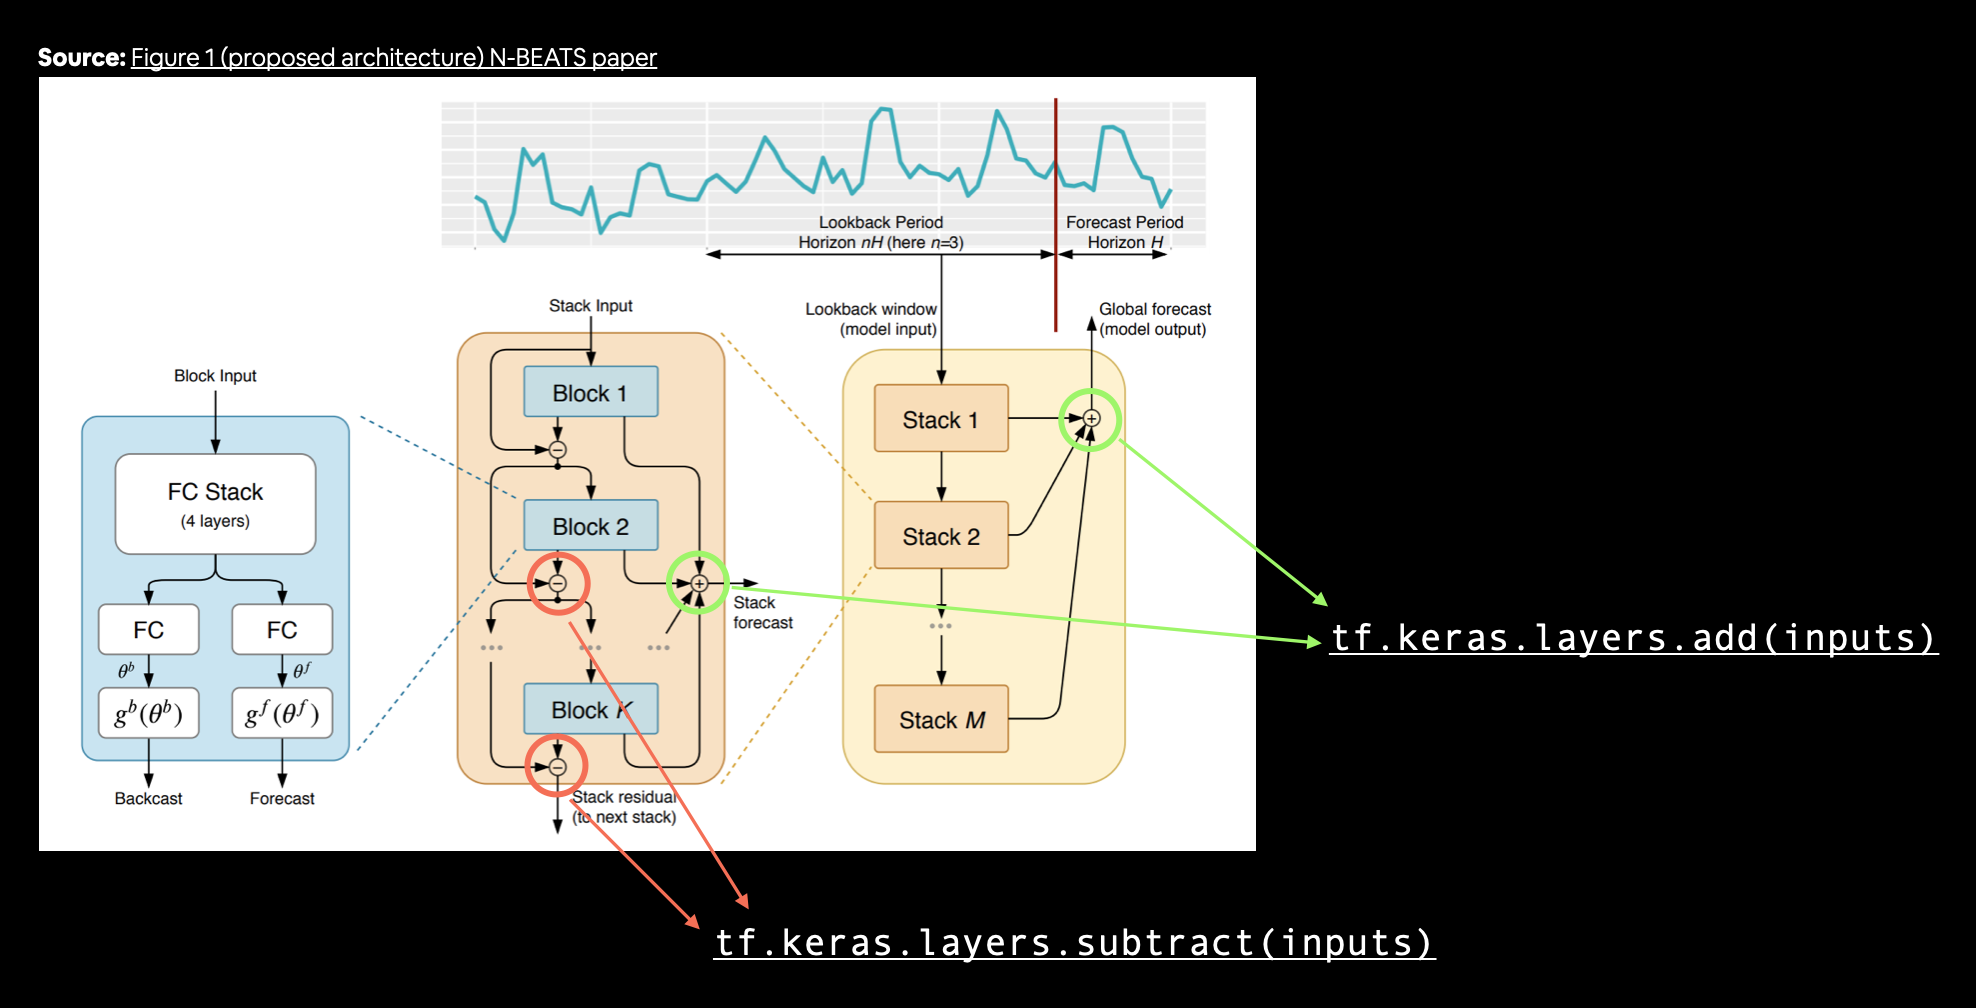

Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.



    What are the benefits of **residual connections**?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the N-BEATS paper).

It's thought that they help avoid the problem of vanishing gradients (patterns learned by a neural network not being passed through to deeper layers).

#Building, compiling and fitting the `N-BEATS algorithm`

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be 
the initial block used for the network, the rest will be created as part of stacks)

2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)

3. Make the initial backcast and forecasts for the model with the layer created in (1)

4. Use a for loop to create stacks of block layers

5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts

6. Create the double residual stacking using subtract and add layers

7. Put the model inputs and outputs together using `tf.keras.Model()`

8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)

9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
    * `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for long period of time without improvement)
    * `tf.keras.callbacks.ReduceLROnPlateau() `- if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [ ]:
## setting the hyperparameters for n_Beat Algorithm: parameters are according to the "NBEATS PAPER"

HORIZON=1
WINDOW_SIZE=7
N_EPOCH=5000
N_NEURONS=512
N_LAYERS=4
N_STACK=30
INPUT_SIZE=WINDOW_SIZE*HORIZON   
THETA_SIZE=WINDOW_SIZE+HORIZON

INPUT_SIZE,THETA_SIZE

(7, 8)

In [ ]:
##setup instances for the NbeatBlock:

%%time
tf.random.set_seed(21)

nbeat_block_layer=NBeatsBlock(input_size=INPUT_SIZE,
                              theta_size=THETA_SIZE,
                              n_neurons=N_NEURONS,
                              n_layers=N_LAYERS,
                              horizon=HORIZON,
                              name=f"NBeatBlock")

## create input to stack
stack_input=tf.keras.layers.Input(shape=(INPUT_SIZE),name='Stack_input')

#create initial backcast and forcast input(backward+horizon)
residual,forecast= nbeat_block_layer(stack_input)


## creating stack of block layer:
for i, _ in enumerate(range(N_STACK-1)):
    backcast,block_forecast=NBeatsBlock(input_size=INPUT_SIZE,
                                        theta_size=THETA_SIZE,
                                        n_neurons=N_NEURONS,
                                        n_layers=N_LAYERS,
                                        horizon=HORIZON,
                              name=f"NBeatBlock{i}")(residual)
    # creating double residual 
    residual=tf.keras.layers.subtract([residual,backcast],name=f'subtract{i}')
    forecast=tf.keras.layers.add([forecast,block_forecast],name=f'add{i}')


model_7=tf.keras.Model(inputs=stack_input,outputs=forecast,name="model_7")

CPU times: user 1.9 s, sys: 19.9 ms, total: 1.92 s
Wall time: 1.92 s


In [ ]:
## compileinh the mokdel_7

model_7.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam())

##fitting the model:
model_7.fit(train_dataset,epochs=N_EPOCH,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=200,restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',Patience=100,verbose=1)])


Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 465: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 475: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 485: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 495: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 505: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 515: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 525: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 535: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 545: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 555: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 565: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 575: ReduceLROnPlateau reducing learni

In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 45ms/step - loss: 568.9772


568.9771728515625

In [ ]:
# Make predictions with N-BEATS model
model_7_preds =tf.squeeze(model_7.predict(test_dataset))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8865.702, 8777.623, 9029.611, 8799.209, 8738.185, 8741.117,
       8682.262, 8527.48 , 8462.604, 8526.145], dtype=float32)>

In [ ]:
 #Evaluate N-BEATS model predictions
model_7_results = evaluate_metrics(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'Mean Square error': 1176941.9,
 'Mean absolute Error': 568.9772,
 'Mean absolute percentage error': 2.5670412,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1084.8695}

In [ ]:
naive_results

{'Mean Square error': 1147547.1250238959,
 'Mean absolute Error': 567.9802273457541,
 'Mean absolute percentage error': 2.516524929982267,
 'Mean_absolute_scaled_error': 0.9989903220205395,
 'Root mean square error': 1071.2362601330744}

In [ ]:
# Plot the N-BEATS model and inspect the architecture
#plot_model(model_7)

In [ ]:
# saving the model
model_7.save("saved_model/model_7.h5")

In [ ]:
load_model_7=tf.keras.models.load_model("/content/saved_model/model_7.h5",custom_objects={"NBeatsBlock":NBeatsBlock})

In [ ]:
load_model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 1s/step - loss: 568.9772


568.9771728515625

###Model 8: Creating an ensemble (stacking different models together)
\
We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a `random normal (Gaussian)` distribution using `He normal` initialization, this'll help estimating the prediction intervals later on.

* 🔑 Note: In your machine leanring experiments, you may have already dealt with examples of ensemble models. Algorithms such as the random forest model are a form of ensemble, it uses a number of randomly created decision trees where each individual tree may perform poorly but when combined gives great results.

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
    ensemble_model=[]
    for i in range(num_iter):
        for loss_functions in loss_fns:
            print(f'optimizing model by reduction:\n {loss_functions}__for {num_epochs}" " epochs ,   model_number:{i}')
            
            model = tf.keras.Sequential([
                  # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
                   # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
                   tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
                  tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
                    tf.keras.layers.Dense(HORIZON)  ])
            
            model.compile(loss=loss_functions,
                           optimizer=tf.keras.optimizers.Adam(),
                            metrics=["mae", "mse"])
            
            model.fit(train_data, epochs=num_epochs,
                      verbose=0, validation_data=test_data,
                      callbacks=[tf.keras.callbacks.EarlyStopping(    monitor='val_loss',  patience=200, restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  patience=100,verbose=1)]        
                     )
            ensemble_model.append(model)
    return ensemble_model



In [ ]:
# list of ensemble moddel:
%%time
ensemble_model=get_ensemble_models(num_iter=5,
                   num_epochs=1000)

optimizing model by reduction:
 mae__for 1000" " epochs ,   model_number:0

Epoch 933: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
optimizing model by reduction:
 mse__for 1000" " epochs ,   model_number:0

Epoch 781: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 881: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reduction:
 mape__for 1000" " epochs ,   model_number:0

Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 579: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reduction:
 mae__for 1000" " epochs ,   model_number:1

Epoch 452: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 552: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reduction:
 mse__for 1000" " epochs ,   model_number:1

Epoch 425: ReduceLROnPlateau reducing learning rate to 0.000100

###Making predictions with an ensemble model:

In [ ]:
# Create a function which uses a list of trained models to make and return a list of prediction
ensemble_preds = []

for model in ensemble_model:
    preds = model.predict(test_dataset) # make predictions with current ensemble model
    ensemble_preds.append(preds)
ensemble_preds=tf.constant(tf.squeeze(ensemble_preds))

ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8829.303 ,  8800.245 ,  9049.223 , ..., 50225.152 , 48637.336 ,
        46191.375 ],
       [ 8798.568 ,  8785.5625,  9059.623 , ..., 49456.867 , 48065.22  ,
        47564.    ],
       [ 8813.164 ,  8752.736 ,  9028.995 , ..., 50357.938 , 48494.254 ,
        46135.625 ],
       ...,
       [ 8749.992 ,  8828.951 ,  9119.854 , ..., 50810.37  , 48262.668 ,
        46904.367 ],
       [ 8729.212 ,  8714.032 ,  9105.54  , ..., 49718.402 , 48046.703 ,
        46248.67  ],
       [ 8798.7   ,  8804.06  ,  9082.345 , ..., 50081.617 , 48885.297 ,
        45249.88  ]], dtype=float32)>

In [ ]:
ensemble_model_results=evaluate_metrics(y_test,
                                       np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_model_results


{'Mean Square error': 1158665.9,
 'Mean absolute Error': 569.4475,
 'Mean absolute percentage error': 2.5643396,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1076.4135}

In [ ]:
ensemble_model_results=evaluate_metrics(y_test,
                                       tf.reduce_mean(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_model_results

{'Mean Square error': 1150751.2,
 'Mean absolute Error': 568.60474,
 'Mean absolute percentage error': 2.569955,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1072.7307}

In [ ]:
model_1_results

{'Mean Square error': 1152402.0,
 'Mean absolute Error': 562.22955,
 'Mean absolute percentage error': 2.5050695,
 'Mean_absolute_scaled_error': 0.9989880388914744,
 'Root mean square error': 1073.4999}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble
Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of WINDOW_SIZE=7 values, the model will predict HORIZION=1.

But what might be more helpful than a single value?

Perhaps a range of values?

>**For example**, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000 and 52,000USD? (note: "$" has been omitted from the previous sentence due to formatting issues)

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

Although the model is predicting 50,000USD (a **point prediction**, or single value in time), the value could actually be within the range 48,000 USD to 52,000 USD (of course, the value could also be outside of this range as well.

These kind of prediction ranges are called **prediction intervals ** or ** uncertainty estimates**. And they're often as important as the forecast itself.

Why?

Because point predictions are almost always going to be wrong. So having a range of values can help with decision making.

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 **(approx=2.0)**standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)


In [ ]:
# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

In [ ]:
ranges=pd.DataFrame(lower, upper)
ranges.head()

,0
8844.551758,8720.311523
8840.493164,8701.069336
9119.713867,9004.200195
8795.582031,8649.980469
8814.903320,8657.047852


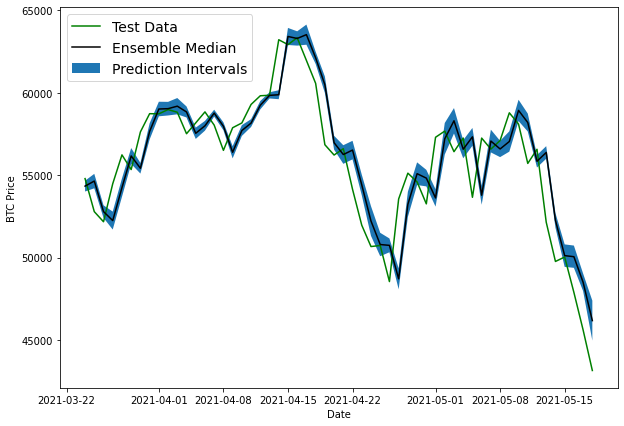

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.mean(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(x_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(x_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(x_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

###Model 9: Train a model on the full historical data to make predictions into future

In [ ]:
HORIZON=1
WINDOW_SIZE=7

In [ ]:
btc_price_windowed.head(10)

,price,block_reward,price+(1),price+(2),price+(3),price+(4),price+(5),price+(6),price+(7)
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
btc_price_window=btc_price_windowed.dropna()

In [ ]:
btc_price_window.head()

,price,block_reward,price+(1),price+(2),price+(3),price+(4),price+(5),price+(6),price+(7)
Date,,,,,,,,,
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,25,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,25,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,25,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
x_all=btc_price_window.drop(['price','block_reward'],axis=1).to_numpy()
y_all=btc_price_window["price"].to_numpy()

In [ ]:
## Set API[pipeline]

feature_dataset_all=tf.data.Dataset.from_tensor_slices(x_all)
label_dataset_all=tf.data.Dataset.from_tensor_slices(y_all)
dataset_all=tf.data.Dataset.zip((feature_dataset_all,label_dataset_all)).batch(1024).prefetch(tf.data.AUTOTUNE)
dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# modelling:
tf.random.set_seed(21)
model_9=tf.keras.Sequential([ 
                             tf.keras.layers.Dense(128,activation="relu"),
                             tf.keras.layers.Dense(128,activation="relu"),
                             tf.keras.layers.Dense(HORIZON)                 ])

## model_9 compiling:
model_9.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam())

## model fitting:
model_9.fit(dataset_all,
          epochs=100,
          verbose=0)

create a function which returns `INTO_FUTURE forecasted` values using a trained model.

To do so, we'll build the following steps:

Function which takes as input:
1. a list of values (the Bitcoin historical data)
> * a trained model (such as` model_9`)
> * a window into the future to predict (our `INTO_FUTURE` variable)
> * the window size a model was trained on `(WINDOW_SIZE) `- the model can only
> * predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last` WINDOW_SIZE` values of the training data)

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
Eventually future predictions will be made using the model's own previous predictions as input

In [ ]:
INTO_FUTURE=14
WINDOW_SIZE=7

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecast( model, into_future, window_size=WINDOW_SIZE) -> list:
    future_forecast = []
    last_window = y_all[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)
    
    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
    return future_forecast

In [ ]:
future_forecast = make_future_forecast( model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55303.43359375

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55303.43359375] -> Prediction: 52267.93359375

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55303.43359375 52267.93359375] -> Prediction: 49058.8046875

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55303.43359375 52267.93359375 49058.8046875 ] -> Prediction: 47695.6328125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55303.43359375
 52267.93359375 49058.8046875  47695.6328125 ] -> Prediction: 45489.6328125

Predicting on: 
 [45604.61575361 43144.47129086 55303.43359375 52267.93359375
 49058.8046875  47695.6328125  45489.6328125 ] -> Prediction: 47931.796875

Predicting on: 
 [43144.47129086 55303.43359375 52267.93359375 49058.

In [ ]:
future_forecast[:10]

[55303.434,
 52267.934,
 49058.805,
 47695.633,
 45489.633,
 47931.797,
 47504.074,
 54211.6,
 50940.074,
 47224.035]

In [ ]:
btc_price_window.tail(10)

,price,block_reward,price+(1),price+(2),price+(3),price+(4),price+(5),price+(6),price+(7)
Date,,,,,,,,,
2021-05-09,58788.209679,6.5,57107.120672,56583.849879,57252.702185,53658.843121,57255.306838,56427.043125,57677.975222
2021-05-10,58102.191426,6.5,58788.209679,57107.120672,56583.849879,57252.702185,53658.843121,57255.306838,56427.043125
2021-05-11,55715.546651,6.5,58102.191426,58788.209679,57107.120672,56583.849879,57252.702185,53658.843121,57255.306838
2021-05-12,56573.555472,6.5,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879,57252.702185,53658.843121
2021-05-13,52147.821187,6.5,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879,57252.702185
2021-05-14,49764.132082,6.5,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.5,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.5,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.5,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426


In [ ]:
## setting dates for predictions:
last_date=btc_price.index[-1]
start_date=last_date + np.timedelta64(1,'D')
end_date=start_date + np.timedelta64(INTO_FUTURE,'D')
future_dates=np.arange(start_date,end_date,dtype='datetime64[D]')
future_dates

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
##another sinple method for date setting for future predictions:
future_date=np.arange('2021-05-19', '2021-06-02', dtype='datetime64[D]')
future_date

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
##inserting new date with known present dates
next_time_steps=np.insert(future_date,0,last_date)
next_time_steps[-20:]

array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
       '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
       '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
future_forecast = np.insert(future_forecast, 0, btc_price.price[-1])
future_forecast

array([43144.473, 55303.434, 52267.934, 49058.805, 47695.633, 45489.633,
       47931.797, 47504.074, 54211.6  , 50940.074, 47224.035, 46633.977,
       45900.89 , 50017.67 , 49842.582], dtype=float32)

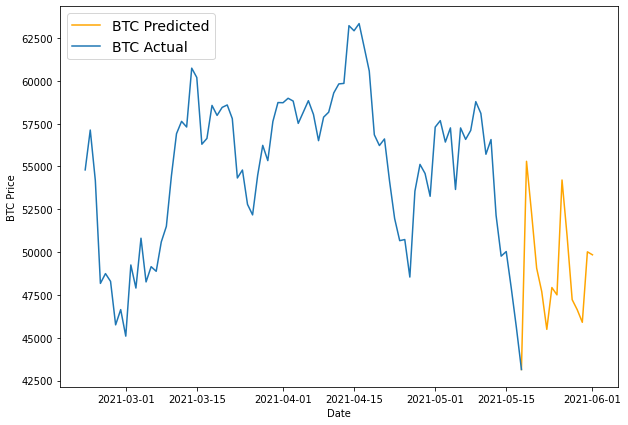

In [ ]:
# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
OFFSET=2700

plt.figure(figsize=(10, 7))
plt.plot(next_time_steps,future_forecast,label='BTC Predicted',color="orange")
plt.plot(btc_price.index[OFFSET:],btc_price.price[OFFSET:],label='BTC Actual')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(loc="upper left", fontsize=14);

In [ ]:

model_results= pd.DataFrame({
                                    "naive_model"           :naive_results,
                                    "Model_1_dense_win7_hor1"   :model_1_results,
                                    "Model_2_dense_win30_hor1"  :model_2_results,
                                    "Model_3_dense_win30_hor7"  :model_3_results,
                                    "Model_4_convid"            :model_4_results,
                                    "MOdel_5_LSTM"              :model_5_results,
                                    "Model_6_multivariate"      :model_6_results,
                                    "MOdel_7_NBeaats"           :model_7_results,
                                    "Model_8_ensemble"          :ensemble_model_results
                                                                                           }).T # transpose

model_results

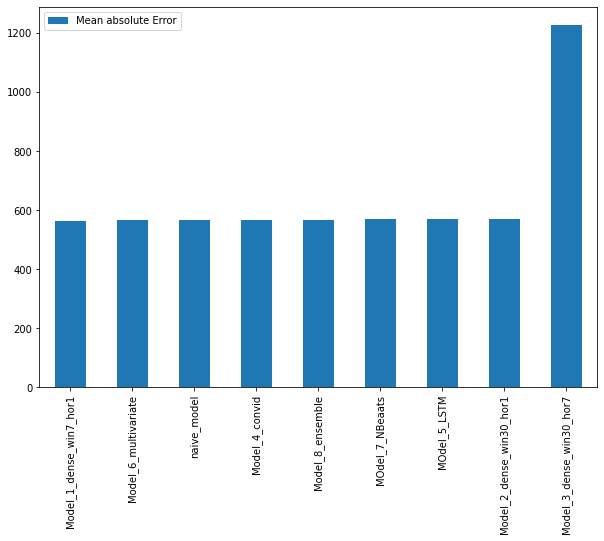

In [ ]:
# Sort model results by MAE and plot them
model_results[["Mean absolute Error"]].sort_values(by="Mean absolute Error").plot(figsize=(10, 7), kind="bar");

* Model_1 with window=7 horizon=1 perform better than others.
* we can check the predicted prices as the taken data is 8 months old, since then prices are avialable in real world, which are not accurate as our model predicted.

#### Why the predicted price are not match OR close to real world prices?
well, it is not easy to predict price values which fluctuates according to real world events and market sentiments.

>**Investments are subject to market risk.**✌✌✌✌